# Nonparametric Tests

* Lecture 12 [Link](https://github.com/bcaffo/MathematicsBiostatisticsBootCamp2/blob/master/lecture12.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2, binom, binom_test, norm, wilcoxon, mannwhitneyu

## Sign Test

The following dataset has the measurement of mercury levels in fish in two different sites. We are interested in studying the differences between these measurements in the two sites.

The null hypothesis states that the population median of the differences is 0. This necessitates that the probability of getting a positive (or a negative) difference is 0.5. The problem then is transformed to a binomial test where the success refers to getting a positive difference with probability 0.5 under the null hypothesis.

In [2]:
fish_data = pd.read_csv('data/mercury_fish.csv')
fish_data.head()

,Fish,SR,P,Diff,Sgn rank
0,1,0.32,0.39,0.07,15.5
1,2,0.40,0.47,0.07,15.5
2,3,0.11,0.11,0.00,NaN
3,4,0.47,0.43,-0.04,-11.0
4,5,0.32,0.42,0.10,20.0


In [3]:
data = fish_data.iloc[:, :3]

In [4]:
data['diff'] = (data['P'] - data['SR'])

In [5]:
# Count of differences greater than zero
cond = data['diff'] >= 0
count = cond.sum()
count

15

The two-sided p-value:

In [6]:
# Probability of getting 15 positive differences or less
p1 = binom.cdf(15, 25, 0.5)

# Probability of getting 10 negative differences or less
p2 = binom.cdf(10, 25, 0.5)

p_val = min(p1, p2) * 2
print('P-value = {:.3f}'.format(p_val))

P-value = 0.424


In [7]:
binom_test(15, 25, 0.5)

0.4243562221527101

We fail to reject the null hypothesis using the sign test. Note that in this test we treated all positive (and negative) differences equally regardless of how big or small the difference is. The signed rank test compensates for some of this loss in information by ranking the differences.

## Signed Rank Test

**Note**: The sum of a sequence of integers is equal to $n(n+1)/2$

In [9]:
cond = data['diff'] == 0
idx = data.loc[~cond, 'diff'].abs().sort_values().index

data['rank'] = 0
data.loc[idx, 'rank'] = np.arange(1, data.loc[idx].shape[0]+1)

In [10]:
# Assigning the mean rank for equal differences
done_vals = []
for diff in data['diff'].abs():
    if np.isclose(diff, done_vals).any():
        continue
        
    cond = np.isclose(data['diff'].abs(), diff)
    data.loc[cond, 'rank'] = data.loc[cond, 'rank'].mean() * np.sign(data.loc[cond, 'diff'])
    done_vals.append(diff)

In [11]:
cond = data['rank'] > 0
rank_sum = data.loc[cond, 'rank'].sum()
rank_sum

194.5

In [12]:
# Removing the ties
n = data.shape[0] - np.isclose(data['diff'], 0.).sum()

# Expected value of the positive rank sum
E = n*(n+1)/4.

# Variance of the positive rank sum
Var = n * (n+1) * (2*n+1) / 24.

stat = (rank_sum - E) / np.sqrt(Var)

p_val = min(norm.cdf(stat), norm.cdf(-stat)) * 2

print('P-value = {:.3f}'.format(p_val))

P-value = 0.204


Computing the signed rank test (Wilcoxon test) using Monte carlo simulation

In [13]:
cond = np.isclose(data['diff'], 0.)
idx = data.loc[~cond].index

ranks = data.loc[idx, 'rank'].to_numpy()
rank_sum = np.where(ranks>0, ranks, 0).sum()

ranks = np.abs(ranks)

In [14]:
n = 1000
count_greater = 0
count_less = 0

for i in range(n):
    signs = np.random.choice([-1, 1], size=ranks.shape[0])
    a = signs * ranks
    rank_sum_iter = np.where(a>0, a, 0).sum()
    
    count_greater += (rank_sum < rank_sum_iter)*1.
    count_less += (rank_sum > rank_sum_iter)*1.
    

p1 = 1. * count_greater / n
p2 = 1. * count_less / n

p_val = min(p1, p2) * 2
print('Monte Carlo P-value: {:.3f}'.format(p_val))

Monte Carlo P-value: 0.186


Using Scipy `wilcoxon`

In [15]:
wilcoxon(data['P'], data['SR'], mode='approx')

WilcoxonResult(statistic=107.0, pvalue=0.21883253814638726)

### Signed Rank Test for Unpaired Data

Example from the lecture

In [16]:
A = np.array([79.98, 80.04, 80.02, 80.04, 80.03, 80.03, 80.04, 79.97, 80.05, 80.03, 80.02, 80, 80.02 ])
A = np.array([A, ['A']*A.shape[0]]).T

B = np.array([80.02, 79.94, 79.98, 79.97, 79.97, 80.03, 79.95, 79.97])
B = np.array([B, ['B']*B.shape[0]]).T

AB = np.concatenate([A, B])
AB = pd.DataFrame(AB, columns=['value', 'method'])
AB['value'] = AB['value'].astype('float')

idx = AB.sort_values(by='value').index
AB.loc[idx, 'rank'] = np.arange(1, AB.shape[0]+1)

done_vals = []
for val in AB['value']:
    if np.isclose(val, done_vals).any():
        continue
    
    cond = np.isclose(AB['value'], val)
    AB.loc[cond, 'rank'] = AB.loc[cond, 'rank'].mean()


# Sum of A, B ranks
cond = AB['method'] == 'A'
A_rank_sum = AB.loc[cond, 'rank'].sum()
B_rank_sum = AB.loc[~cond, 'rank'].sum()

In [17]:
cond = AB['method'] == 'A'
na = cond.sum()
nb = (~cond).sum()
# Expected value of the sum of ranks of A method
E = na*(na + nb + 1)/2.

Var = na*nb*(na + nb + 1)/12.

stat = (A_rank_sum - E) / np.sqrt(Var)

p_val = min(norm.cdf(stat), norm.cdf(-stat)) * 2

print('P-value = {:.4f}'.format(p_val))

P-value = 0.0074


Using Scipy `mannwhitneyu`

In [18]:
A = np.array([79.98, 80.04, 80.02, 80.04, 80.03, 80.03, 80.04, 79.97, 80.05, 80.03, 80.02, 80, 80.02 ])
B = np.array([80.02, 79.94, 79.98, 79.97, 79.97, 80.03, 79.95, 79.97])
mannwhitneyu(A, B, alternative='two-sided')

MannwhitneyuResult(statistic=89.0, pvalue=0.007497146445668576)

**Using Monte Carlo simulation:**

Under the null hypothesis, the labeling of the measurements is not important (both methods are assumed to be equivalent). We randomly assign the labels to the measurements and compute the number of times the sum of ranks of A exceeds (or is less than) the observed sum of ranks.

In [19]:
n = 10000

A = np.array([79.98, 80.04, 80.02, 80.04, 80.03, 80.03, 80.04, 79.97, 80.05, 80.03, 80.02, 80, 80.02 ])
B = np.array([80.02, 79.94, 79.98, 79.97, 79.97, 80.03, 79.95, 79.97])

ranks = AB['rank'].to_numpy()
# 1 refers to A and 0 refers to B
labels = np.array([1]*A.shape[0] + [0]*B.shape[0])

count_greater = 0
count_less = 0


for i in range(n):
    np.random.shuffle(labels)
    
    A_idx = labels == 1
    
    A_rank_sum_iter = ranks[A_idx].sum()
    
    count_greater += (A_rank_sum_iter > A_rank_sum)*1.
    count_less += (A_rank_sum_iter < A_rank_sum)*1.
    

p1 = 1. * count_greater / n
p2 = 1. * count_less / n

p_val = min(p1, p2) * 2
print('Monte Carlo P-value: {:.4f}'.format(p_val))

Monte Carlo P-value: 0.0052


### Permutation Test
In this test, the original data is used instead of ranks. Under the null hypothesis, the measurements can be from both methods with equal probability. We randomly assign the labels and compute a test statistic (say t-test or the difference of the means of both samples) for every permutation and compare with the observed statistic.

Monte Carlo P-value: 0.004


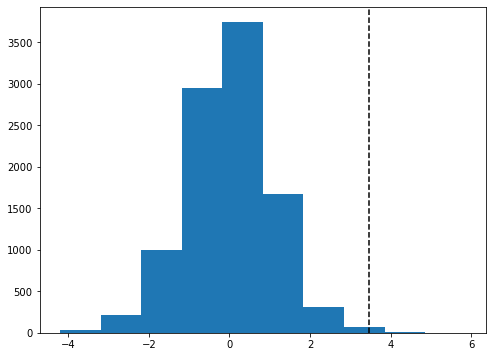

In [20]:
from scipy.stats import ttest_ind
A = np.array([79.98, 80.04, 80.02, 80.04, 80.03, 80.03, 80.04, 79.97, 80.05, 80.03, 80.02, 80, 80.02 ])
B = np.array([80.02, 79.94, 79.98, 79.97, 79.97, 80.03, 79.95, 79.97])

obs_stat, p = ttest_ind(A, B)
n = 10000

vals = np.concatenate([A, B])

na = A.shape[0]

count_greater = 0
count_less = 0

stats = np.zeros(n)
for i in range(n):
    np.random.shuffle(vals)
    
    # The first na are assumed to be measurements from method A
    A_iter = vals[:na]
    B_iter = vals[na:]
    
    iter_stat, _ = ttest_ind(A_iter, B_iter)
    stats[i] = iter_stat
    
    count_greater += (iter_stat > obs_stat)*1.
    count_less += (iter_stat < obs_stat)*1.
    
p1 = 1. * count_greater / n
p2 = 1. * count_less / n

p_val = min(p1, p2) * 2
print('Monte Carlo P-value: {:.3f}'.format(p_val))

plt.figure(figsize=(8, 6))
plt.hist(stats)
plt.axvline(obs_stat, color='black', linestyle='--')
plt.show()